In [65]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import seaborn as sns
import tempfile, os, zipfile
from PIL import Image
import requests
from matplotlib import pyplot as plt
#mport squarify
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import csv
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report
from tensorflow.keras import mixed_precision

from os import listdir
from os.path import isfile, join

In [66]:
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.com.am/d/1mFfgWQxggpeUQ'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)

download_url = response.json()['href']

download_response = requests.get(download_url)


file = tempfile.TemporaryFile()
file.write(download_response.content)
fzip = zipfile.ZipFile(file)
fzip.extractall('./TJ_data')

file.close()
fzip.close()


In [67]:
listdir("./TJ_data") # Tom&Jerry_dataset
listdir("./TJ_data/Tom&Jerry_dataset")

['archive.zip']

In [68]:
fzip = zipfile.ZipFile("./TJ_data/Tom&Jerry_dataset/archive.zip")
fzip.extractall('./TJ_data/dataset')

fzip.close()

In [69]:
dataset_dir = "./TJ_data/dataset"
tom_dir = "./TJ_data/dataset/tom_and_jerry/tom_and_jerry/tom"
jerry_dir = "./TJ_data/dataset/tom_and_jerry/tom_and_jerry/jerry"
tj_0_dir = "./TJ_data/dataset/tom_and_jerry/tom_and_jerry/tom_jerry_0"
tj_1_dir = "./TJ_data/dataset/tom_and_jerry/tom_and_jerry/tom_jerry_1"

print(listdir(dataset_dir))


['challenges.csv', 'ground_truth.csv', 'tom_and_jerry']


In [70]:
import os
import numpy as np
from PIL import Image

folder_path = './TJ_data/dataset/tom_and_jerry/tom_and_jerry/'


def images_to_array(folder_path, class_name):

    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    data = []
    target= []
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)

        img = Image.open(image_path)

        img = img.resize((224, 224))

        img_array = np.array(img, dtype=float) / 255.0  # Нормализация значений пикселей к диапазону [0, 1]
        img_vector = img_array.flatten()

        data.append(img_vector)
        target.append(class_names.index(class_name))


    result_array = np.array(data)
    target_array = np.array(target)
    return result_array, target_array

folder_path = './TJ_data/dataset/tom_and_jerry/tom_and_jerry/'
class_names =  ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']
result_array = None
target_result_array = None


for class_name in class_names:
    class_directory = os.path.join(folder_path, class_name)
    class_array, target_array = images_to_array(class_directory, class_name)

    if result_array is None:
        result_array = class_array
    else:
        result_array = np.concatenate((result_array, class_array))
    if target_result_array is None:
        target_result_array=target_array
    else:
        target_result_array=np.concatenate((target_result_array, target_array))

print(result_array.shape)
print(target_result_array.shape)


(5478, 150528)
(5478,)


In [71]:
!pip install tensorflow
import tensorflow as tf


In [72]:
IMAGE_DIRECTORY = "/content/TJ_data/dataset/tom_and_jerry/tom_and_jerry"

In [73]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(IMAGE_DIRECTORY,
                                                                 label_mode = "categorical",
                                                                 image_size = (224, 224) ,
                                                                 seed = 42)

Found 5478 files belonging to 4 classes.


In [74]:
# Load the validation dataset
val_data = tf.keras.preprocessing.image_dataset_from_directory(IMAGE_DIRECTORY,
                                                                label_mode = "categorical",
                                                                image_size = (224, 224),
                                                                seed = 42)

Found 5478 files belonging to 4 classes.


In [75]:
# Load the test dataset
test_data = tf.keras.preprocessing.image_dataset_from_directory(IMAGE_DIRECTORY,
                                                                label_mode = "categorical",
                                                                image_size = (224, 224),
                                                                seed = 42,
                                                                shuffle = False)

Found 5478 files belonging to 4 classes.


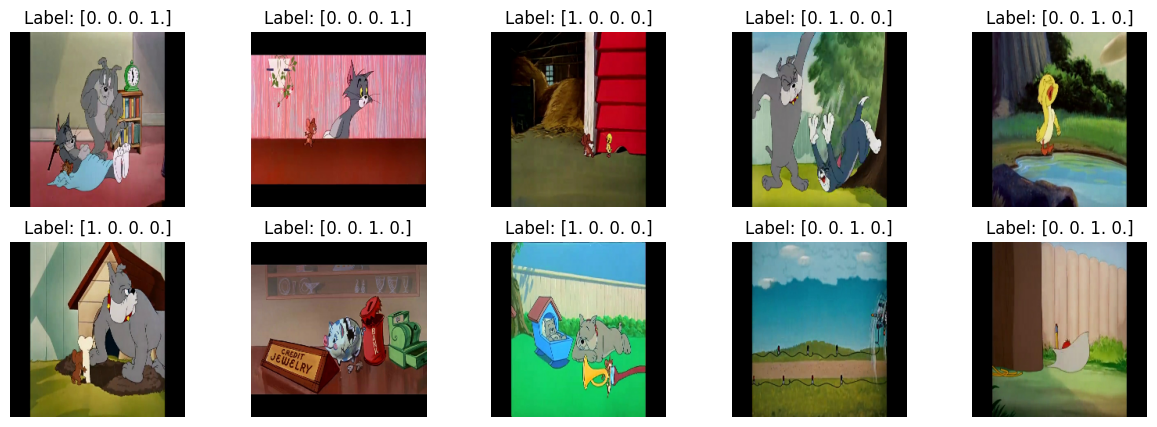

In [76]:
plt.figure(figsize=(15, 5))
for i, (images, target_result_array) in enumerate(train_data.take(1)):
    for j in range(10):
        ax = plt.subplot(2, 5, j + 1)
        plt.imshow(images[j].numpy().astype("uint8"))
        plt.title(f"Label: {target_result_array[j].numpy()}")
        plt.axis("off")
plt.show()

In [77]:
#Labeling categories
label_categories = {
    0: "Jerry",
    1: "Tom",
    2: "None",
    3: "Both"
}

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal', seed = 42),
  preprocessing.RandomRotation(0.2, seed = 42),
  preprocessing.RandomHeight(0.2, seed = 42),
  preprocessing.RandomWidth(0.2, seed = 42),
  preprocessing.RandomZoom(0.2, seed = 42)])

In [79]:
# Callback to save the best model based on validation accuracy during training
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('Data/Checkpoint',
                                                      save_best_only = True,
                                                      monitor = "val_accuracy")

# Callback to reduce the learning rate when the validation accuracy stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_accuracy",
                                                 factor = 0.2,
                                                 patience = 2,
                                                 min_lr = 1e-7)

# Callback to log training history to a csv file
base_csv_logger = tf.keras.callbacks.CSVLogger('Data/Base Model History.csv')
ft_csv_logger = tf.keras.callbacks.CSVLogger('Data/Fine-Tuned Model History.csv')

In [80]:
mixed_precision.set_global_policy(policy="mixed_float16")


In [81]:
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False) # Load the EfficientNetV2B0 model without the top layer
base_model.trainable = False # Freeze the base model layers to prevent backpropagation through them

inputs = layers.Input(shape = (224, 224, 3)) # Input layer

x = data_augmentation(inputs) # Apply data augmentation to the image

x = base_model(inputs, training = False) # Pass the image through the base model
x = layers.Dropout(.2)(x) # Apply dropout to prevent overfitting

x = layers.GlobalAveragePooling2D()(x) # Perform global average pooling to reduce the spatial dimensions
x = layers.Dropout(.3)(x)

x = layers.Dense(4)(x) # Output layer
outputs = layers.Activation("softmax", dtype = tf.float32)(x)

# Create the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [82]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 5124

In [83]:
model.fit(train_data,
          epochs = 20,
          steps_per_epoch = len(train_data),
          validation_data = val_data,
          validation_steps = len(val_data),
          callbacks = [model_checkpoint, reduce_lr, base_csv_logger])

Epoch 1/20
172/172 [==============================] - 48s 235ms/step - loss: 1.0695 - accuracy: 0.5416 - val_loss: 0.8046 - val_accuracy: 0.7019 - lr: 0.0010
Epoch 2/20
172/172 [==============================] - 37s 215ms/step - loss: 0.7876 - accuracy: 0.7046 - val_loss: 0.6690 - val_accuracy: 0.7674 - lr: 0.0010
Epoch 3/20
172/172 [==============================] - 37s 218ms/step - loss: 0.6951 - accuracy: 0.7459 - val_loss: 0.5922 - val_accuracy: 0.8069 - lr: 0.0010
Epoch 4/20
172/172 [==============================] - 37s 215ms/step - loss: 0.6419 - accuracy: 0.7683 - val_loss: 0.5435 - val_accuracy: 0.8246 - lr: 0.0010
Epoch 5/20
172/172 [==============================] - 39s 227ms/step - loss: 0.6052 - accuracy: 0.7738 - val_loss: 0.5107 - val_accuracy: 0.8388 - lr: 0.0010
Epoch 6/20
172/172 [==============================] - 33s 194ms/step - loss: 0.5821 - accuracy: 0.7895 - val_loss: 0.4862 - val_accuracy: 0.8483 - lr: 0.0010
Epoch 7/20
172/172 [==============================] 

In [84]:
# Оценка модели cnn_model на валидационном наборе данных
loss, accuracy = model.evaluate(train_data)

print(f'Потери (Loss): {loss}')
print(f'Точность (Accuracy): {accuracy}')

172/172 [==============================] - 4s 20ms/step - loss: 0.3411 - accuracy: 0.8980
Потери (Loss): 0.3410938084125519
Точность (Accuracy): 0.8979554772377014


In [85]:
base_csv_logger = tf.keras.callbacks.CSVLogger('Data/Base Model History.csv')
ft_csv_logger = tf.keras.callbacks.CSVLogger('Data/Fine-Tuned Model History.csv')

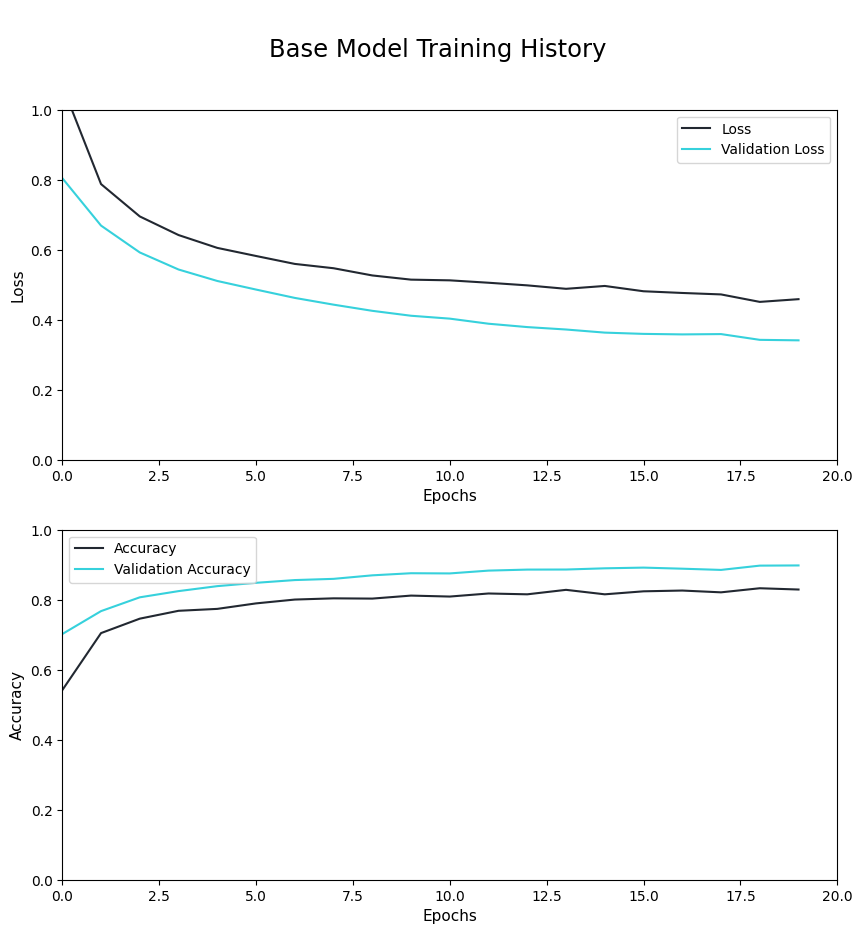

In [86]:
# Load the base model's training history
history = pd.read_csv('Data/Base Model History.csv')

# Extract the values for loss, val_loss, accuracy, and val_accuracy
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Define number of epochs
epochs = range(len(loss))

# Plot the training history using two subplots (for loss and accuracy)
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

fig.suptitle("\nBase Model Training History", fontsize = 17.5)

ax[0].plot(epochs, loss, label = 'Loss', color = "#222831")
ax[0].plot(epochs, val_loss, label = 'Validation Loss', color = "#36D1DC")
ax[0].set_xlim(0, 20)
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Epochs', fontsize = 11)
ax[0].set_ylabel('Loss', fontsize = 11)
ax[0].legend()

ax[1].plot(epochs, accuracy, label = 'Accuracy', color = "#222831")
ax[1].plot(epochs, val_accuracy, label = 'Validation Accuracy', color = "#36D1DC")
ax[1].set_xlim(0, 20)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs', fontsize = 11)
ax[1].set_ylabel('Accuracy', fontsize = 11)
ax[1].legend();


In [87]:
base_model.trainable = True

# Compiling the model
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 4.0000e-06),
              metrics = ["accuracy"])

In [88]:
# Training the fine-tuned model
history = model.fit(train_data,
                    epochs = 20,
                    steps_per_epoch = len(train_data),
                    validation_data = val_data,
                    validation_steps = len(val_data),
                    callbacks = [model_checkpoint, reduce_lr, ft_csv_logger])

Epoch 1/20
172/172 [==============================] - 95s 293ms/step - loss: 0.4099 - accuracy: 0.8538 - val_loss: 0.2784 - val_accuracy: 0.9158 - lr: 4.0000e-06
Epoch 2/20
172/172 [==============================] - 49s 284ms/step - loss: 0.3618 - accuracy: 0.8649 - val_loss: 0.2409 - val_accuracy: 0.9294 - lr: 4.0000e-06
Epoch 3/20
172/172 [==============================] - 49s 285ms/step - loss: 0.3162 - accuracy: 0.8865 - val_loss: 0.2075 - val_accuracy: 0.9379 - lr: 4.0000e-06
Epoch 4/20
172/172 [==============================] - 46s 267ms/step - loss: 0.2808 - accuracy: 0.9023 - val_loss: 0.1824 - val_accuracy: 0.9467 - lr: 4.0000e-06
Epoch 5/20
172/172 [==============================] - 50s 290ms/step - loss: 0.2445 - accuracy: 0.9120 - val_loss: 0.1595 - val_accuracy: 0.9567 - lr: 4.0000e-06
Epoch 6/20
172/172 [==============================] - 49s 288ms/step - loss: 0.2252 - accuracy: 0.9206 - val_loss: 0.1407 - val_accuracy: 0.9611 - lr: 4.0000e-06
Epoch 7/20
172/172 [========

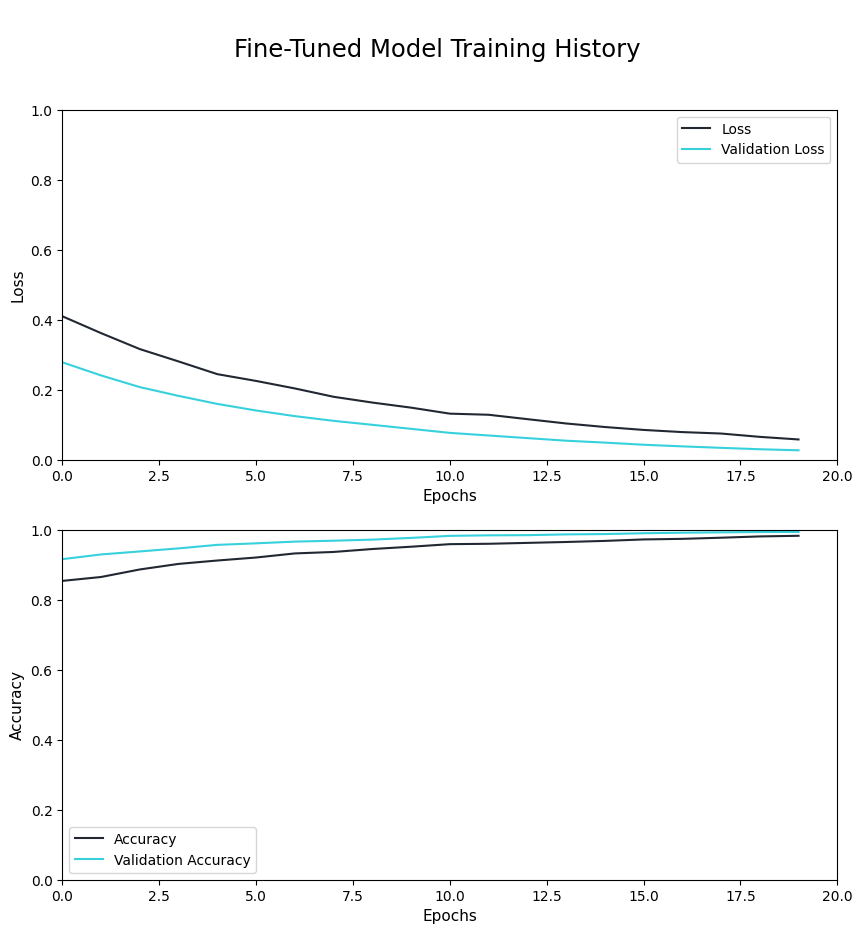

In [89]:
# Load the fine-tuned model's training history
history = pd.read_csv('Data/Fine-Tuned Model History.csv')

# Extract the values for loss, val_loss, accuracy, and val_accuracy
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Define number of epochs
epochs = range(len(loss))

# Plot the training history using two subplots (for loss and accuracy)
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

fig.suptitle("\nFine-Tuned Model Training History", fontsize = 17.5)

ax[0].plot(epochs, loss, label = 'Loss', color = "#222831")
ax[0].plot(epochs, val_loss, label = 'Validation Loss', color = "#36D1DC")
ax[0].set_xlim(0, 20)
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Epochs', fontsize = 11)
ax[0].set_ylabel('Loss', fontsize = 11)
ax[0].legend()

ax[1].plot(epochs, accuracy, label = 'Accuracy', color = "#222831")
ax[1].plot(epochs, val_accuracy, label = 'Validation Accuracy', color = "#36D1DC")
ax[1].set_xlim(0, 20)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs', fontsize = 11)
ax[1].set_ylabel('Accuracy', fontsize = 11)
ax[1].legend();

In [90]:
model.load_weights('Data/Checkpoint')


In [91]:
accuracy = model.evaluate(test_data)[1] * 100

172/172 [==============================] - 4s 20ms/step - loss: 0.0269 - accuracy: 0.9936


In [92]:
# Predictions the test data
test_pred = model.predict(test_data)

# Getting the highest probabilty prediction
test_pred = np.argmax(test_pred, axis = 1)

# Creating an empty list to store the true labels
test_true = []

for images, labels in test_data.unbatch():
  test_true.append(labels.numpy().argmax())

172/172 [==============================] - 5s 19ms/step


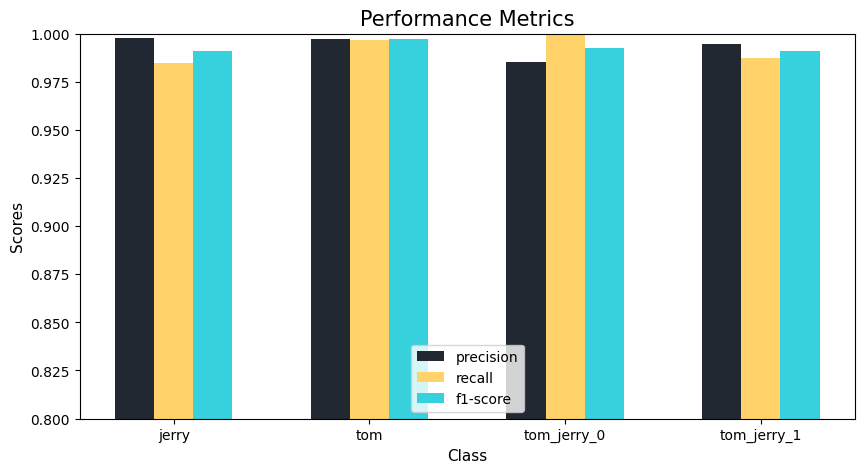

In [93]:
# Calculate the classification report
report = classification_report(test_true, test_pred, output_dict = True)

# Define the metrics to use
metrics = ["precision", "recall", "f1-score"]

# Initialize a list to store the scores for each class
class_scores = []
for i in range(4):
    class_scores.append([report[str(i)][metric] for metric in metrics])

# Plot the data
fig, ax = plt.subplots(figsize = (10, 5))

bar_width = 0.2
for i, scores in enumerate(class_scores):
    ax.bar(i - bar_width, scores[0], bar_width, color = "#222831")
    ax.bar(i, scores[1], bar_width, color = "#FFD369")
    ax.bar(i + bar_width, scores[2], bar_width, color = "#36D1DC")

ax.set_xlabel("Class", fontsize = 11)
ax.set_ylabel("Scores", fontsize = 11)
ax.set_ylim(0.80, 1)
ax.legend(metrics)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_names)
ax.set_title("Performance Metrics", fontsize = 15);

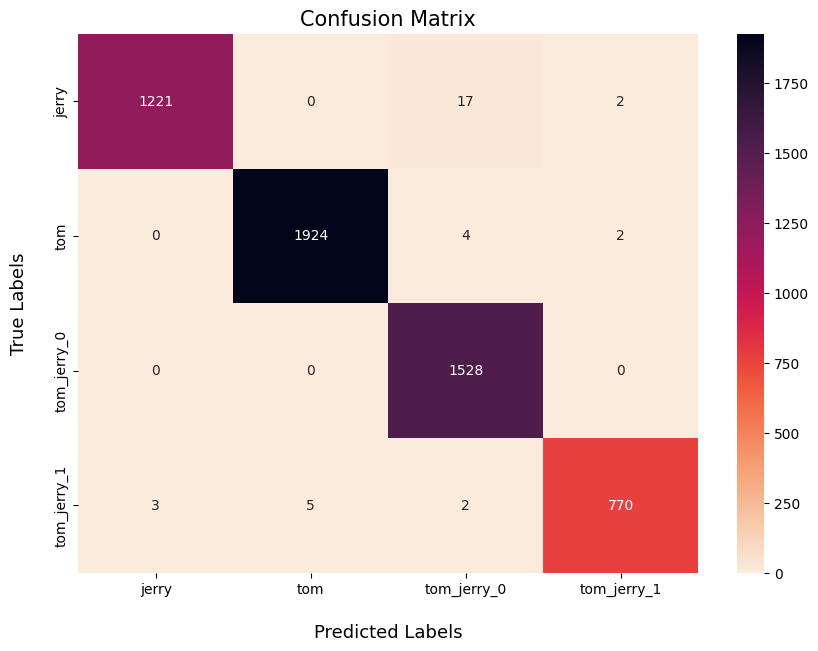

In [94]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the confusion matrix
cm = tf.math.confusion_matrix(test_true, test_pred)

# Convert the confusion matrix to a numpy array
cm = cm.numpy()

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(cm,
            annot=True,
            fmt='',
            ax=ax,
            cmap='rocket_r')

ax.set_yticklabels(class_names, va="center")
ax.set_xticklabels(class_names, ha="center")
ax.set_xlabel('\nPredicted Labels', fontsize=13)
ax.set_ylabel('True Labels\n', fontsize=13)

plt.title("Confusion Matrix", fontsize=15)
plt.show()
